### WTF did we learn last week?

1. Marginal probabilities are always larger than conditional probablities (t/f)? Why?
2. Bayes theorem only applies to single numbers (t/f)? Why?
3. The posterior can have it's maximal value unrepresented in the likelihood function (t/f)? Why?


### Ways to solve for a posterior distribution over parameters

The most difficult part of estimating posteriors is to solve for the marginal likelihood, given that it requires integration over potentially many parameters. 

1. **Analytical**
    - When the functional form of the likeihood * prior is equivalent to the prior, the prior and likelihood are said to be "conjugate" and the marginal likelihood can be computed analytically. This means there is a mathemtical equation that one can leverage to solve for the posterior without difficult or incalculable integration.Such is the case with a beta prior and Bernoulli likelihood as was the case in the example above tossing coins. 
   
   
2. **Numerical approimation via a grid of relevant parameters points**
    - The integral is approximated by a sum of several discrete values. This is what we did in the example last class when we dealth with 11 candidate values for $\theta$, or the coin's bias. We could have computed the posterior analytically, which just means plugging in one's evidence into an equation to compute the posterior. When in continuous space, one can discretize it by choosing e.g., 1,000 values spanning the full space of 0 to 1 in the beta distribution, and used a weighted sum to approximate the integral. Remember, the integral

The marginal likelihood involves estimating the probability of the data given all relevant parameter settings under consideration. Many models have **multiple parameters**: $(Data|\theta,\beta,\alpha,\gamma,\delta,\epsilon)$. 

In this situation, if one uses 1,000 parameter settings for each parameter, **the number of combinations of parameters = 1000^6**, which is a number many computers cannot chug through when approximating an integral numerically.


### Using MCMC to compute the posterior without Bayes

Sampling $\theta$ from the posterior distribution. You do this via an algorithm that essentially uses randomness and simple decision rules to visit the relative frequency of candidate $\theta$ values that are present in the posterior distribution.

### Algorithm

1. Start with a guess of $\theta$ and calculate its $\theta$ by computing $p(Data|\theta)p(\theta)$. Thus, one still needs to specify a prior and a likleihood function to do MCMC. 


2. Randomly choose a new $\theta$ from a "jumping" distribution. Jumping just means, am I going to jump to larger or smaller $\theta$ value from my current $\theta$.


3. A jumping distribution could be $ jump \sim  \mathcal{N} (0,\sigma)$ where a given jump, either larger (positive) or smaller (negative) from one's current $\theta$ is determined from randomly sampling from this distribution (centered on staying where one is at). 


4. Use this equation to decide to jump or stay where one is currently at:
    - $p_{jump}=\text{min}\,\,(1,\frac{p(Data|\theta_{jump})p(\theta_{jump})}{p(Data|\theta_{current})p(\theta_{current})})$
    
    Let's break this down a bit: The probability of jumping to a new value is determined by the ratio of the "probability" (it's the joint probability of $\theta$ and one's data) of the current $\theta$ and the proposed $\theta$ one can jump to. What happens if the proposed value is greater than current value?


5. Each time you sample a given $\theta$, record it: this is a **sample** from the posterior! In the long-run, sampling in this way will approximate the **actual posterior distribution**. Pretty cool.


### A note on terms

If you see "metropolis" or "gibbs" algorithms, these are *instances* of MCMC.


### Using MCMC to recover two parameters: 2 coins, flipped simultaneously, each with their own bias

$p(\theta_1,\theta_2|Data)$. The data will consist of {H,T} for N times we flip both coins.
* note here that $\theta_1$ and $\theta_2$ are independent of each other, but they need not be. If, for instance, they were made by the same mint, they would not be. This would require hierarchical modelling, which I promise we will get to soon!


In [14]:
"""
Use this program as a template for experimenting with the Metropolis algorithm
applied to 2 parameters called theta1,theta2 defined on the domain [0,1]x[0,1].

"""

from __future__ import division
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
plt.style.use('seaborn-darkgrid')
import ipympl



# Define the likelihood function.
# The input argument is a vector: theta = [theta1 , theta2]

def likelihood(theta):
    # Data are constants, specified here:
    z1, N1, z2, N2 = 24, 100, 82, 100
    likelihood = (theta[0]**z1 * (1-theta[0])**(N1-z1)
                 * theta[1]**z2 * (1-theta[1])**(N2-z2))
    return likelihood


# Define the prior density function.
# The input argument is a vector: theta = [theta1 , theta2]
def prior(theta):
    # Here's a beta-beta prior:
    a1, b1, a2, b2 = 3, 3, 3, 3
    prior = beta.pdf(theta[0], a1, b1) * beta.pdf(theta[1], a2, b2) 
    return prior



### Defining our priors and parameters when there are multiple parameters

Why is there a mutlitplication symbol in both the prior and the likelihood?

What condition must be met in order to derive the distributions in this way?

Building blocks:

$p(\theta_{1}|\theta_{2})=p(\theta_{1})$ -- what is this assumption?

$p(\theta_{1} \, \cap \, \theta_{2})=?$



In [15]:

# Define the relative probability of the target distribution, as a function 
# of theta.  The input argument is a vector: theta = [theta1 , theta2].
# For our purposes, the value returned is the UNnormalized posterior prob.
def target_rel_prob(theta):
    if ((theta >= 0.0).all() & (theta <= 1.0).all()):
        target_rel_probVal =  likelihood(theta) * prior(theta)
    else:
        # This part is important so that the Metropolis algorithm
        # never accepts a jump to an invalid parameter value.
        target_rel_probVal = 0.0
    return target_rel_probVal

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 200 # arbitrary large number

# Initialize the vector that will store the results.
trajectories = np.zeros((3,traj_length,2))

# Specify where to start the trajectory
trajectories[0,0,] = [0.50, 0.50] # arbitrary start values of the two param's
trajectories[1,0, ] = [0.1, 0.9] # arbitrary start values of the two param's
trajectories[2,0, ] = [0.05, 0.1] # arbitrary start values of the two param's

# Specify the burn-in period.
burn_in = 0

# Initialize accepted, rejected counters, just to monitor performance.
n_accepted = [0,0,0]
n_rejected = [0,0,0]

# Specify the seed, so the trajectory can be reproduced.
np.random.seed(47405)

### A multivariate normal jumping distribution

Why multivariate?
See below, run the code on the covariance matrix. Why do we need a covariance matrix?

In [16]:
# This is the variance of the jumping distribution.
# It must be a covariance matrix
n_dim, sd1, sd2 = 2, 0.2, 0.2
covar_mat = [[sd1**2, 0], [0, sd2**2]]
print(covar_mat)

[[0.04000000000000001, 0], [0, 0.04000000000000001]]


why .04 -- what is this value?

<IPython.core.display.Javascript object>


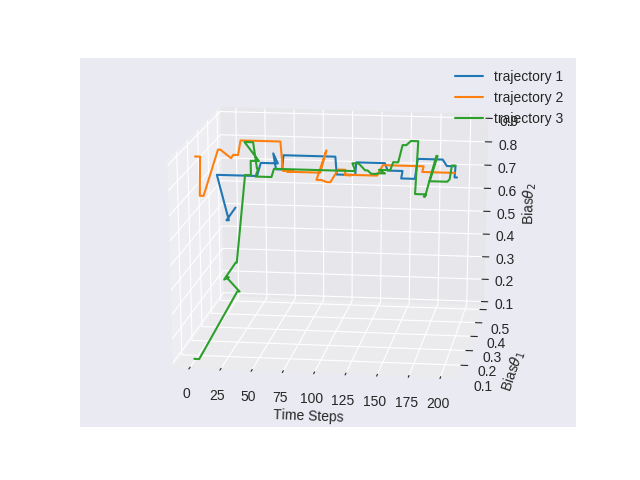

In [17]:
for starting_point in range(3):
# Now generate the random walk. step is the step in the walk.
    for step in range(traj_length-1):
        current_position = trajectories[starting_point,step, ]
        # Use the proposal distribution to generate a proposed jump.
        # The shape and variance of the proposal distribution can be changed
        # to whatever you think is appropriate for the target distribution.
        proposed_jump = np.random.multivariate_normal(mean=np.zeros((n_dim)),
                                                     cov=covar_mat)
        # Compute the probability of accepting the proposed jump.
        prob_accept = np.minimum(1, target_rel_prob(current_position + proposed_jump)
                                / target_rel_prob(current_position))
        # Generate a random uniform value from the interval [0,1] to
        # decide whether or not to accept the proposed jump.
        if np.random.rand() < prob_accept:
            # accept the proposed jump
            trajectories[starting_point,step+1, ] = current_position + proposed_jump
            # increment the accepted counter, just to monitor performance
            if step > burn_in:
                n_accepted[starting_point] += 1
        else:
            # reject the proposed jump, stay at current position
            trajectories[starting_point,step+1, ] = current_position
            # increment the rejected counter, just to monitor performance
            if step > burn_in:
                n_rejected[starting_point] += 1
            

# # Extract just the post-burnIn portion of the trajectory.
# accepted_traj = trajectories

# # Compute the means of the accepted points.
# mean_traj =  np.mean(accepted_traj, axis=0)
# # Compute the standard deviations of the accepted points.
# stdTraj =  np.std(accepted_traj, axis=0)

time_points=np.linspace(1,traj_length,traj_length)



fig = plt.figure()
ax = fig.gca(projection='3d')
#trajectory 1
x = time_points
y = trajectories[0,:,0]#bias of coin1
z = trajectories[0,:,1] #bias of coin2

#trajectory 2
y2 = trajectories[1,:,0]#bias of coin1
z2 = trajectories[1,:,1] #bias of coin2

#trajectory 3
y3 = trajectories[2,:,0]#bias of coin1
z3 = trajectories[2,:,1] #bias of coin2
ax.plot(x, y, z, label='trajectory 1')
ax.plot(x,y2,z2,label='trajectory 2')
ax.plot(x,y3,z3,label='trajectory 3')

ax.legend()
ax.set_xlabel('Time Steps')
ax.set_ylabel('Bias'  r'$\theta_{1}$')
ax.set_zlabel('Bias'  r'$\theta_{2}$')
#mat
plt.show()


### Things to check

Do the chains overlap (representativeness)

When the chains do not overlap at the beginning of the chains, this is called a "burn in" period. It's typical to remove these samples from the collection of samples that will eventually comprise the estimate of the posterior.

### What it looks like done well

[[0.04000000000000001, 0], [0, 0.04000000000000001]]


<IPython.core.display.Javascript object>


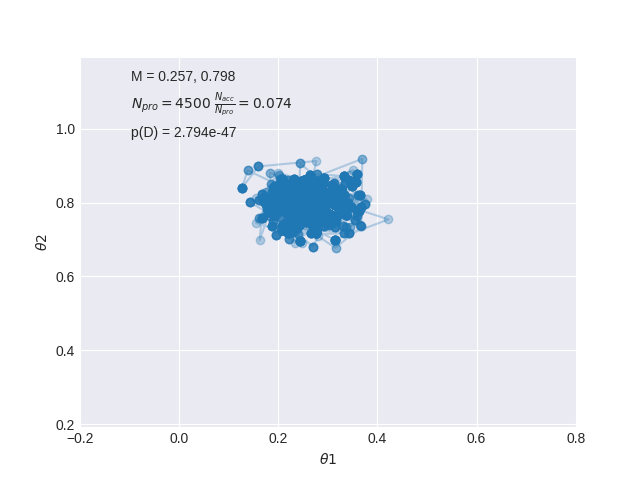

[1.20846902e-45 1.20846902e-45 1.20846902e-45 ... 5.95366359e-46
 5.95366359e-46 5.95366359e-46]


<IPython.core.display.Javascript object>


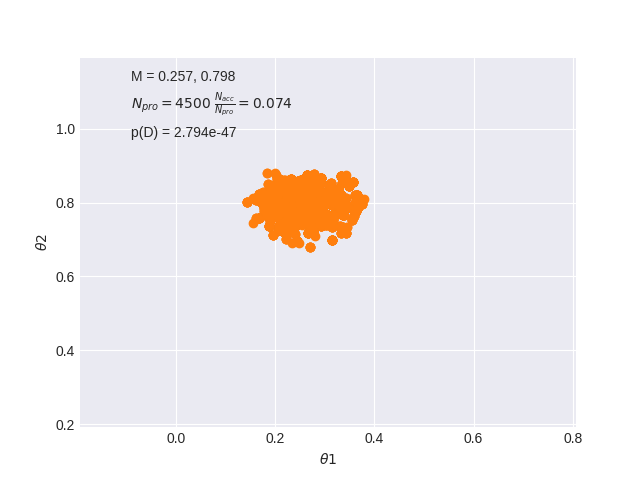

In [12]:
"""
Use this program as a template for experimenting with the Metropolis algorithm
applied to 2 parameters called theta1,theta2 defined on the domain [0,1]x[0,1].

"""

from __future__ import division
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
plt.style.use('seaborn-darkgrid')
import ipympl



# Define the likelihood function.
# The input argument is a vector: theta = [theta1 , theta2]

def likelihood(theta):
    # Data are constants, specified here:
    z1, N1, z2, N2 = 24, 100, 82, 100
    likelihood = (theta[0]**z1 * (1-theta[0])**(N1-z1)
                 * theta[1]**z2 * (1-theta[1])**(N2-z2))
    return likelihood


# Define the prior density function.
# The input argument is a vector: theta = [theta1 , theta2]
def prior(theta):
    # Here's a beta-beta prior:
    a1, b1, a2, b2 = 3, 3, 3, 3
    prior = beta.pdf(theta[0], a1, b1) * beta.pdf(theta[1], a2, b2) 
    return prior
         
# Define the relative probability of the target distribution, as a function 
# of theta.  The input argument is a vector: theta = [theta1 , theta2].
# For our purposes, the value returned is the UNnormalized posterior prob.
def target_rel_prob(theta):
    if ((theta >= 0.0).all() & (theta <= 1.0).all()):
        target_rel_probVal =  likelihood(theta) * prior(theta)
    else:
        # This part is important so that the Metropolis algorithm
        # never accepts a jump to an invalid parameter value.
        target_rel_probVal = 0.0
    return target_rel_probVal

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number

# Initialize the vector that will store the results.
trajectory = np.zeros((traj_length, 2))

# Specify where to start the trajectory
trajectory[0, ] = [0.50, 0.50] # arbitrary start values of the two param's

# Specify the burn-in period.
burn_in = int(np.ceil(.1 * traj_length)) # arbitrary number

# Initialize accepted, rejected counters, just to monitor performance.
n_accepted = 0
n_rejected = 0

# Specify the seed, so the trajectory can be reproduced.
np.random.seed(47405)

# This is the variance of the jumping distribution.
# It must be a covariance matrix
n_dim, sd1, sd2 = 2, 0.2, 0.2
covar_mat = [[sd1**2, 0], [0, sd2**2]]
print(covar_mat)

# Now generate the random walk. step is the step in the walk.
for step in range(traj_length-1):
    current_position = trajectory[step, ]
    # Use the proposal distribution to generate a proposed jump.
    # The shape and variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposed_jump = np.random.multivariate_normal(mean=np.zeros((n_dim)),
                                                 cov=covar_mat)
    # Compute the probability of accepting the proposed jump.
    prob_accept = np.minimum(1, target_rel_prob(current_position + proposed_jump)
                            / target_rel_prob(current_position))
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[step+1, ] = current_position + proposed_jump
        # increment the accepted counter, just to monitor performance
        if step > burn_in:
            n_accepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[step+1, ] = current_position
        # increment the rejected counter, just to monitor performance
        if step > burn_in:
            n_rejected += 1

            
# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Begin making inferences by using the sample generated by the
# Metropolis algorithm.

# Extract just the post-burnIn portion of the trajectory.
accepted_traj = trajectory[burn_in:]

# Compute the means of the accepted points.
mean_traj =  np.mean(accepted_traj, axis=0)
# Compute the standard deviations of the accepted points.
stdTraj =  np.std(accepted_traj, axis=0)

# Plot the trajectory of the last 500 sampled values.
plt.plot(accepted_traj[:,0], accepted_traj[:,1], marker='o', alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta2$')

# Display means in plot.
plt.plot(0, label='M = %.3f, %.3f' % (mean_traj[0], mean_traj[1]), alpha=0.0)
# Display rejected/accepted ratio in the plot.
plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)
# Evidence for model, p(D).
# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is binomial.
a =   mean_traj * ((mean_traj*(1-mean_traj)/stdTraj**2) - np.ones(n_dim))
b = (1-mean_traj) * ( (mean_traj*(1-mean_traj)/stdTraj**2) - np.ones(n_dim))
# For every theta value in the posterior sample, compute 
# beta.pdf(theta, a, b) / likelihood(theta) * prior(theta)
# This computation assumes that likelihood and prior are properly normalized,
# i.e., not just relative probabilities.

wtd_evid = np.zeros(np.shape(accepted_traj)[0])
for idx in range(np.shape(accepted_traj)[0]):
    wtd_evid[idx] = (beta.pdf(accepted_traj[idx,0],a[0],b[0] )
        * beta.pdf(accepted_traj[idx,1],a[1],b[1]) /
        (likelihood(accepted_traj[idx,]) * prior(accepted_traj[idx,])))

p_data = 1 / np.mean(wtd_evid)
# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)
plt.legend(loc='upper left')
plt.savefig('Figure_8.3.png')

# Estimate highest density region by evaluating posterior at each point.
accepted_traj = trajectory[burn_in:]
npts = np.shape(accepted_traj)[0] 
post_prob = np.zeros((npts))
for ptIdx in range(npts):
    post_prob[ptIdx] = target_rel_prob(accepted_traj[ptIdx,])
print(post_prob)
# Determine the level at which credmass points are above:
credmass = 0.95
waterline = np.percentile(post_prob, (credmass))

HDI_points = accepted_traj[post_prob > waterline, ]

plt.figure()
plt.plot(HDI_points[:,0], HDI_points[:,1], 'C1o')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta2$')

# Display means in plot.
plt.plot(0, label='M = %.3f, %.3f' % (mean_traj[0], mean_traj[1]), alpha=0.0)
# Display rejected/accepted ratio in the plot.
plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)
# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)
plt.legend(loc='upper left')

plt.savefig('Figure_8.3_HDI.png')

plt.show()



## Ways to determine if MCMC "worked"

### Representativeness

Are values representing those in the posterior? Does the initial value of the chain influence the sampled distribution? The answers to these questions explain when the sampling procedure "gets stuck" in regions that prevent it from fully sampling the posterior.

### Accuracy

Are the central tendencies and range of the distribution across multiple intiations of MCMC?

### Efficiency

Is it computable within a reaonable time?